FM(Factorization Machine)系列主要参考美团的[《深入FFM原理与实践》](https://tech.meituan.com/2016/03/03/deep-understanding-of-ffm-principles-and-practices.html)这篇博客内容做介绍并实现，首先介绍一下原理

### 一.FM原理
大家可能用过sklearn中的这个多项式特征处理函数：*`sklearn.preprocessing.PolynomialFeatures`*，它作用是就是将原始特征扩展为多项式特征，比如原始特征为$a,b$，那么它会做如下扩展：   

$$
[a,b]\rightarrow [1,a,b,a^2,ab,b^2]
$$  

而FM的初衷便是对这组新特征做线性建模，一般地，它可以表示如下：   

$$
y(x)=w_0+\sum_{i=1}^nw_ix_i+\sum_{i=1}^{n-1}\sum_{j=i+1}^nw_{ij}x_ix_j
$$  

FM通常不会对平方项建模（比如上面的$a^2,b^2$），这里$n$代表样本的特征数量，$x_i$是第$i$个特征值，$w_0,w_i,w_{ij}$是模型参数，到这里大家可能会有疑惑，我们干嘛不先通过多项式特征处理函数做转换，然后再接着做一个线性回归或者logistic回归之类的不就行了吗？那这个...FM拿它何用？如果按照刚刚的操作其实是有很大问题的，主要有两点问题：    

（1）**参数爆炸**；   

（2）**高维稀疏**；  

第一点比较容易理解，对于$n$个特征，$w_{ij}$将会有$\frac{n(n-1)}{2}$项，形象点说就是平常随意用到的100个特征，扩展后将会有5000个，而参数越多，如果没有足够的数据做训练，模型很容易陷入过拟合，而对于第二点，经常处理离散特征的同学会很容易理解，比如下图
![avatar](./source/17_FM_one-hot1.png)  

包含有三个特征（最左侧的是标签），且都是离散特征，而对于离散特征我们经常做的一种操作便是one-hot转换，转换后的结果如下图：   

![avatar](./source/17_FM_one-hot2.png)  

如果我们在对这些特征做多项式转换，可以发现转后的20多个特征中，仅仅只有3个非零特征，这就意味着绝大部分的$x_ix_j$将会是0，而损失函数关于$w_{ij}$的导数必然会包含有$x_ix_j$这一项，这就意味$w_{ij}$大部分情况下就是个摆设，很难被更新到，而FM便可以解决这两个问题，它假设$w_{ij}$由两个向量的内积生成：   

$$
w_{ij}:=<v_i,v_j>
$$  

这里，$v_i$表示第$i$个特征的隐向量，其向量长度为$k(k<<n)$，通常$k=4$即可，这时FM模型方程如下：   

$$
y(x)=w_0+\sum_{i=1}^nw_ix_i+\sum_{i=1}^{n-1}\sum_{j=i+1}^n<v_i,v_j>x_ix_j
$$   
进一步的，我们可以将其化简为如下形式：   

$$
y(x)=w_0+\sum_{i=1}^nw_ix_i+\frac{1}{2}\sum_{f=1}^k((\sum_{i=1}^nv_{i,f}x_i)^2-\sum_{i=1}^nv_{i,f}^2x_i^2)
$$  

这里，$v_{i,f}$表示向量$v_i$的第$f$个元素，上述化简用到了这样的关系：$ab+ac+bc=\frac{1}{2}((a+b+c)^2-(a^2+b^2+c^2))$，接下来我们可以进一步看看梯度：   

$$
\frac{\partial}{\partial\theta}y(x)=\left\{\begin{matrix}
1 &\theta=w_0 \\ 
x_i &\theta=w_i \\ 
x_i\sum_{j=1}^nv_{j,f}x_j-v_{i,f}x_i^2 & \theta=v_{i,f}
\end{matrix}\right.
$$  

可以发现前面的两个问题可以被FM解决了，第一个问题，参数量从$n(n-1)/2$降低到了$kn$，第二个高维稀疏导致参数无法被训练的问题，对于$v_{i,f}$只要$x_i$不为0，且所有$x_j,j=1,2,...,n$中有一个不为0，那么梯度$\frac{\partial}{\partial v_{i,f}}y(x)$就不为0，这比$x_ix_j$不为0的条件松了很多

### 二.代码实现
这里就对FM应用到回归任务做简单实现，更多的功能扩展放到FFM中，下面推导一下损失函数对参数的梯度，假设样本$x$对应的标签为$t$，那么损失函数可以表示如下：   

$$
L(\theta)=\frac{1}{2}(y(x)-t)^2
$$   

那么：   

$$
\frac{\partial L(\theta)}{\partial y(x)}=y(x)-t
$$   

再根据链式求导有：   

$$
\frac{\partial L(\theta)}{\partial \theta}=\frac{\partial L(\theta)}{\partial y(x)}\frac{\partial y(x)}{\partial\theta}\\
=(y(x)-t)\cdot \left\{\begin{matrix}
1 &\theta=w_0 \\ 
x_i &\theta=w_i \\ 
x_i\sum_{j=1}^nv_{j,f}x_j-v_{i,f}x_i^2 & \theta=v_{i,f}
\end{matrix}\right.
$$

In [1]:
"""
FM因子分解机的简单实现，只实现了损失函数为平方损失的回归任务，更多功能扩展请使用后续的FFM
代码封装到ml_models.fm中
"""
import numpy as np
from tqdm import tqdm


class FM(object):
    def __init__(self, epochs=1, lr=1e-3, batch_size=2, hidden_dim=4, lamb=1e-3, alpha=1e-3, normal=True,
                 solver='adam', rho_1=0.9, rho_2=0.999):
        """

        :param epochs: 迭代轮数
        :param lr: 学习率
        :param batch_size:
        :param hidden_dim:隐变量维度
        :param lamb:l2正则项系数
        :param alpha:l1正则项系数
        :param normal:是否归一化，默认用min-max归一化
        :param solver:优化方式，包括sgd,adam,默认adam
        :param rho_1:adam的rho_1的权重衰减,solver=adam时生效
        :param rho_2:adam的rho_2的权重衰减,solver=adam时生效
        """
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.lamb = lamb
        self.alpha = alpha
        self.solver = solver
        self.rho_1 = rho_1
        self.rho_2 = rho_2
        # 初始化参数
        self.w = None  # w_0,w_i
        self.V = None  # v_{i,f}
        # 归一化
        self.normal = normal
        if normal:
            self.xmin = None
            self.xmax = None

    def _y(self, X):
        """
        实现y(x)的功能
        :param X:
        :return:
        """
        # 去掉第一列bias
        X_ = X[:, 1:]
        X_V = X_ @ self.V
        X_V_2 = X_V * X_V
        X_2_V_2 = (X_ * X_) @ (self.V * self.V)
        pol = 0.5 * np.sum(X_V_2 - X_2_V_2, axis=1)
        return X @ self.w.reshape(-1) + pol

    def fit(self, X, y):
        if self.normal:
            self.xmin = X.min(axis=0)
            self.xmax = X.max(axis=0)
            X = (X - self.xmin) / self.xmax
        # 记录loss
        losses = []
        n_sample, n_feature = X.shape
        x_y = np.c_[np.ones(n_sample), X, y]
        # 调整一下学习率
        self.lr = max(self.lr, 1 / n_feature)
        # 初始化参数
        self.w = np.random.random((n_feature + 1, 1)) * 1e-3
        self.V = np.random.random((n_feature, self.hidden_dim)) * 1e-3
        if self.solver == 'adam':
            # 缓存梯度一阶，二阶估计
            w_1 = np.zeros_like(self.w)
            V_1 = np.zeros_like(self.V)
            w_2 = np.zeros_like(self.w)
            V_2 = np.zeros_like(self.V)
        # 更新参数
        count = 0
        for _ in tqdm(range(self.epochs)):
            np.random.shuffle(x_y)
            for index in tqdm(range(x_y.shape[0] // self.batch_size)):
                count += 1
                batch_x_y = x_y[self.batch_size * index:self.batch_size * (index + 1)]
                batch_x = batch_x_y[:, :-1]
                batch_y = batch_x_y[:, -1:]
                # 计算y(x)-t
                y_x_t = self._y(batch_x).reshape((-1, 1)) - batch_y
                # 更新w
                if self.solver == 'sgd':
                    self.w = self.w - (self.lr * (np.sum(y_x_t * batch_x, axis=0) / self.batch_size).reshape(
                        (-1, 1)) + self.lamb * self.w + self.alpha * np.where(self.w > 0, 1, 0))
                elif self.solver == 'adam':
                    w_reg = self.lamb * self.w + self.alpha * np.where(self.w > 0, 1, 0)
                    w_grad = (np.sum(y_x_t * batch_x, axis=0) / self.batch_size).reshape(
                        (-1, 1)) + w_reg
                    w_1 = self.rho_1 * w_1 + (1 - self.rho_1) * w_grad
                    w_2 = self.rho_2 * w_2 + (1 - self.rho_2) * w_grad * w_grad
                    w_1_ = w_1 / (1 - np.power(self.rho_1, count))
                    w_2_ = w_2 / (1 - np.power(self.rho_2, count))
                    self.w = self.w - (self.lr * w_1_) / (np.sqrt(w_2_) + 1e-8)

                # 更新 V
                batch_x_ = batch_x[:, 1:]
                V_X = batch_x_ @ self.V
                X_2 = batch_x_ * batch_x_
                # 从i,f单个元素逐步更新有点慢
                # for i in range(self.V.shape[0]):
                #     for f in range(self.V.shape[1]):
                #         if self.solver == "sgd":
                #             self.V[i, f] -= self.lr * (
                #                 np.sum(y_x_t.reshape(-1) * (batch_x_[:, i] * V_X[:, f] - self.V[i, f] * X_2[:, i]))
                #                 / self.batch_size + self.lamb * self.V[i, f] + self.alpha * (self.V[i, f] > 0))
                #         elif self.solver == "adam":
                #             v_reg = self.lamb * self.V[i, f] + self.alpha * (self.V[i, f] > 0)
                #             v_grad = np.sum(y_x_t.reshape(-1) * (
                #                 batch_x_[:, i] * V_X[:, f] - self.V[i, f] * X_2[:, i])) / self.batch_size + v_reg
                #             V_1[i, f] = self.rho_1 * V_1[i, f] + (1 - self.rho_1) * v_grad
                #             V_2[i, f] = self.rho_2 * V_2[i, f] + (1 - self.rho_2) * v_grad * v_grad
                #             v_1_ = V_1[i, f] / (1 - np.power(self.rho_1, count))
                #             v_2_ = V_2[i, f] / (1 - np.power(self.rho_2, count))
                #             self.V[i, f] = self.V[i, f] - (self.lr * v_1_) / (np.sqrt(v_2_) + 1e-8)

                # 从隐变量的维度进行更新
                for f in range(self.V.shape[1]):
                    if self.solver == 'sgd':
                        V_grad = np.sum(
                            y_x_t.reshape((-1, 1)) * (batch_x_ * V_X[:, f].reshape((-1, 1)) - X_2 * self.V[:, f]),
                            axis=0)
                        self.V[:, f] = self.V[:, f] - self.lr * V_grad - self.lamb * self.V[:, f] - self.alpha * (
                            self.V[:, f] > 0)
                    elif self.solver == 'adam':
                        V_reg = self.lamb * self.V[:, f] + self.alpha * (self.V[:, f] > 0)
                        V_grad = np.sum(
                            y_x_t.reshape((-1, 1)) * (batch_x_ * V_X[:, f].reshape((-1, 1)) - X_2 * self.V[:, f]),
                            axis=0) + V_reg
                        V_1[:, f] = self.rho_1 * V_1[:, f] + (1 - self.rho_1) * V_grad
                        V_2[:, f] = self.rho_2 * V_2[:, f] + (1 - self.rho_2) * V_grad * V_grad
                        V_1_ = V_1[:, f] / (1 - np.power(self.rho_1, count))
                        V_2_ = V_2[:, f] / (1 - np.power(self.rho_2, count))
                        self.V[:, f] = self.V[:, f] - (self.lr * V_1_) / (np.sqrt(V_2_) + 1e-8)

                # 计算loss
                loss = np.sum(np.abs(y - self.predict(X))) / n_sample
                losses.append(loss)
        return losses

    def predict(self, X):
        """
        :param X:
        :return:
        """
        if self.normal:
            X = (X - self.xmin) / self.xmax
        n_sample, n_feature = X.shape
        X_V = X @ self.V
        X_V_2 = X_V * X_V
        X_2_V_2 = (X * X) @ (self.V * self.V)
        pol = 0.5 * np.sum(X_V_2 - X_2_V_2, axis=1)
        return np.c_[np.ones(n_sample), X] @ self.w.reshape(-1) + pol

### 三.测试

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#造伪数据
data1 = np.linspace(1, 10, num=100)
data2 = np.linspace(1, 10, num=100) + np.random.random(size=100)
target = data1 * 2 + data2 * 1 + 10 * data1 * data2 + np.random.random(size=100)
data = np.c_[data1, data2]

In [4]:
#训练模型
model = FM()
losses = model.fit(data, target)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.78it/s]


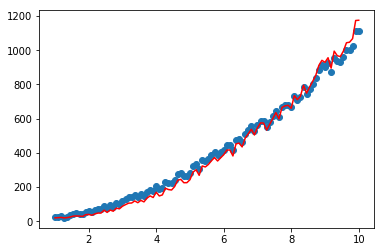

In [5]:
#查看拟合效果
plt.scatter(data[:, 0], target)
plt.plot(data[:, 0], model.predict(data), color='r')

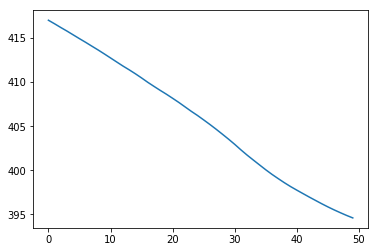

In [6]:
#查看损失值变化
plt.plot(range(0, len(losses)), losses)